In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import struct
import os

plt.rcParams['figure.figsize'] = [12, 8]

---
## Загрузка и подготовка изображения

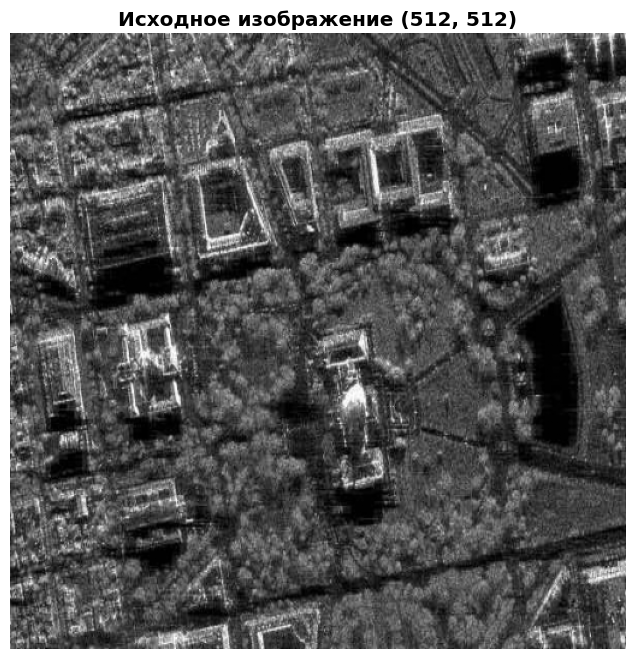

Размер: (512, 512)
Память: 262144 байт


In [ ]:
# Загрузка изображения
img = cv2.imread('sar_1_gray.jpg', cv2.IMREAD_GRAYSCALE)

# Приводим к размеру 512x512 для наглядности сжатия
img = cv2.resize(img, (512, 512))

plt.imshow(img, cmap='gray')
plt.title(f'Исходное изображение {img.shape}', fontweight='bold')
plt.axis('off')
plt.show()

print(f'Размер: {img.shape}')
print(f'Память: {img.nbytes} байт')

---
## Сохранение в бинарный файл

In [ ]:
def save_binary(image, path):
    with open(path, 'wb') as f:
        h, w = image.shape
        f.write(struct.pack('II', h, w))
        f.write(image.tobytes())

def load_binary(path):
    with open(path, 'rb') as f:
        h, w = struct.unpack('II', f.read(8))
        data = np.frombuffer(f.read(), dtype=np.uint8)
        return data.reshape(h, w)

# Сохраняем оригинал
save_binary(img, 'original.bin')
original_size = os.path.getsize('original.bin')

print(f'Оригинал сохранён: {original_size:,} байт')

Оригинал сохранён: 262,152 байт


---
## Вейвлет-преобразование Хаара

In [ ]:
def haar_1d(row):
    """1D преобразование Хаара"""
    n = len(row)
    result = np.zeros(n, dtype=np.float32)
    
    # Среднее и разность пар
    result[:n//2] = (row[0::2] + row[1::2]) / 2  # Low
    result[n//2:] = (row[0::2] - row[1::2]) / 2  # High
    
    return result

def haar_2d(image):
    """2D преобразование Хаара -> LL, LH, HL, HH"""
    h, w = image.shape
    img = image.astype(np.float32)
    
    # По строкам
    temp = np.zeros_like(img)
    for i in range(h):
        temp[i] = haar_1d(img[i])
    
    # По столбцам
    h2, w2 = h // 2, w // 2
    LL = np.zeros((h2, w2), dtype=np.float32)
    LH = np.zeros((h2, w2), dtype=np.float32)
    HL = np.zeros((h2, w2), dtype=np.float32)
    HH = np.zeros((h2, w2), dtype=np.float32)
    
    for j in range(w):
        col = haar_1d(temp[:, j])
        if j < w2:
            LL[:, j] = col[:h2]
            HL[:, j] = col[h2:]
        else:
            LH[:, j - w2] = col[:h2]
            HH[:, j - w2] = col[h2:]
    
    return LL, LH, HL, HH

# Применяем
LL, LH, HL, HH = haar_2d(img)

print(f'Исходное: {img.shape}')
print(f'LL: {LL.shape}, LH: {LH.shape}, HL: {HL.shape}, HH: {HH.shape}')

Исходное: (512, 512)
LL: (256, 256), LH: (256, 256), HL: (256, 256), HH: (256, 256)


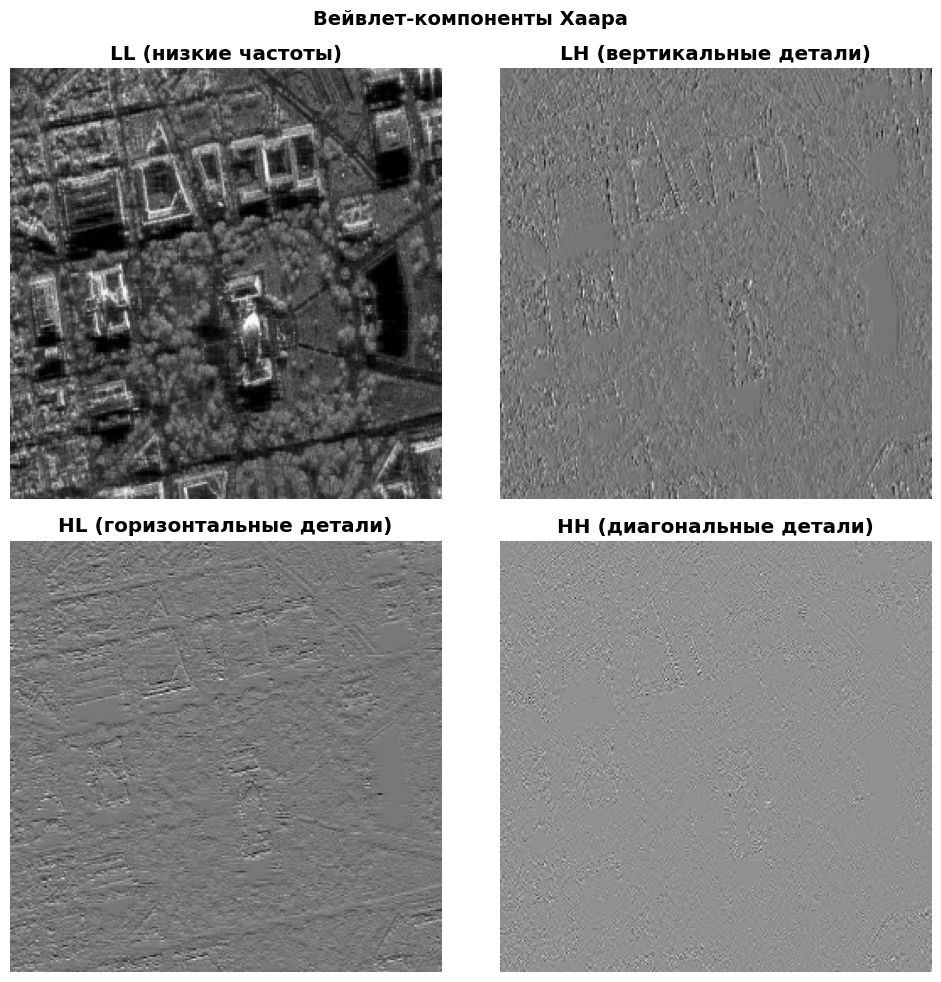

In [ ]:
# Визуализация
def normalize(arr):
    mn, mx = arr.min(), arr.max()
    return ((arr - mn) / (mx - mn + 1e-8) * 255).astype(np.uint8)

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

axes[0,0].imshow(normalize(LL), cmap='gray')
axes[0,0].set_title('LL (низкие частоты)', fontweight='bold')
axes[0,0].axis('off')

axes[0,1].imshow(normalize(LH), cmap='gray')
axes[0,1].set_title('LH (вертикальные детали)', fontweight='bold')
axes[0,1].axis('off')

axes[1,0].imshow(normalize(HL), cmap='gray')
axes[1,0].set_title('HL (горизонтальные детали)', fontweight='bold')
axes[1,0].axis('off')

axes[1,1].imshow(normalize(HH), cmap='gray')
axes[1,1].set_title('HH (диагональные детали)', fontweight='bold')
axes[1,1].axis('off')

plt.suptitle('Вейвлет-компоненты Хаара', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

---
## Квантование высокочастотных компонент

In [ ]:
def quantize(arr, levels=4):
    """Квантование на заданное число уровней"""
    mn, mx = arr.min(), arr.max()
    if mx == mn:
        return arr
    
    step = (mx - mn) / levels
    result = np.zeros_like(arr)
    
    for i in range(levels):
        lo = mn + i * step
        hi = mn + (i + 1) * step
        center = (lo + hi) / 2
        mask = (arr >= lo) & (arr < hi) if i < levels-1 else (arr >= lo)
        result[mask] = center
    
    return result

# Квантование (4 уровня)
LH_q = quantize(LH, 4)
HL_q = quantize(HL, 4)
HH_q = quantize(HH, 4)

print('Квантование на 4 уровня:')
print(f'  LH: {len(np.unique(LH_q))} уникальных значений')
print(f'  HL: {len(np.unique(HL_q))} уникальных значений')
print(f'  HH: {len(np.unique(HH_q))} уникальных значений')

Квантование на 4 уровня:
  LH: 4 уникальных значений
  HL: 4 уникальных значений
  HH: 4 уникальных значений


---
## Сжатие

In [ ]:
def save_compressed(LL, path):
    # Нормализуем к uint8
    mn, mx = LL.min(), LL.max()
    LL_u8 = ((LL - mn) / (mx - mn) * 255).astype(np.uint8)
    
    with open(path, 'wb') as f:
        h, w = LL_u8.shape
        f.write(struct.pack('II', h, w))
        f.write(LL_u8.tobytes())
    
    return os.path.getsize(path)

# Сохраняем сжатый файл
compressed_size = save_compressed(LL, 'compressed.bin')

print(f'Сжатый файл: {compressed_size:,} байт')

Сжатый файл: 65,544 байт


---
## Сравнение размеров

In [ ]:
ratio = original_size / compressed_size
savings = (1 - compressed_size / original_size) * 100

print('=' * 55)
print('РЕЗУЛЬТАТЫ СЖАТИЯ')
print('=' * 55)
print(f"{'Формат':<20} {'Размер':<15} {'Коэфф.'}")
print('-' * 55)
print(f"{'Оригинал (BIN)':<20} {original_size:>10,} байт   1.0:1")
print(f"{'Сжатый (LL only)':<20} {compressed_size:>10,} байт   {ratio:.1f}:1")
print('=' * 55)
print(f'Экономия: {savings:.1f}%')
print(f'Коэффициент сжатия: {ratio:.1f}:1')

РЕЗУЛЬТАТЫ СЖАТИЯ
Формат               Размер          Коэфф.
-------------------------------------------------------
Оригинал (BIN)          262,152 байт   1.0:1
Сжатый (LL only)         65,544 байт   4.0:1
Экономия: 75.0%
Коэффициент сжатия: 4.0:1


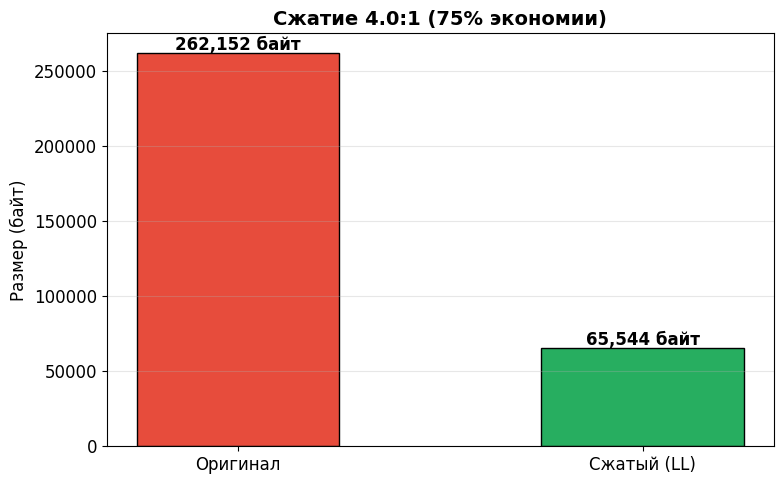

In [ ]:
# График
labels = ['Оригинал', 'Сжатый (LL)']
sizes = [original_size, compressed_size]
colors = ['#e74c3c', '#27ae60']

plt.figure(figsize=(8, 5))
bars = plt.bar(labels, sizes, color=colors, edgecolor='black', width=0.5)

for bar, size in zip(bars, sizes):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2000,
             f'{size:,} байт', ha='center', fontweight='bold')

plt.ylabel('Размер (байт)')
plt.title(f'Сжатие {ratio:.1f}:1 ({savings:.0f}% экономии)', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

---
## Восстановление и оценка качества

In [ ]:
# Загрузка сжатого
LL_loaded = load_binary('compressed.bin')

# Восстановление через интерполяцию
restored = cv2.resize(LL_loaded, img.shape[::-1], interpolation=cv2.INTER_LINEAR)

# Метрики качества
mse = np.mean((img.astype(float) - restored.astype(float)) ** 2)
psnr = 20 * np.log10(255 / np.sqrt(mse)) if mse > 0 else 100

print(f'MSE: {mse:.2f}')
print(f'PSNR: {psnr:.2f} dB')

MSE: 174.18
PSNR: 25.72 dB


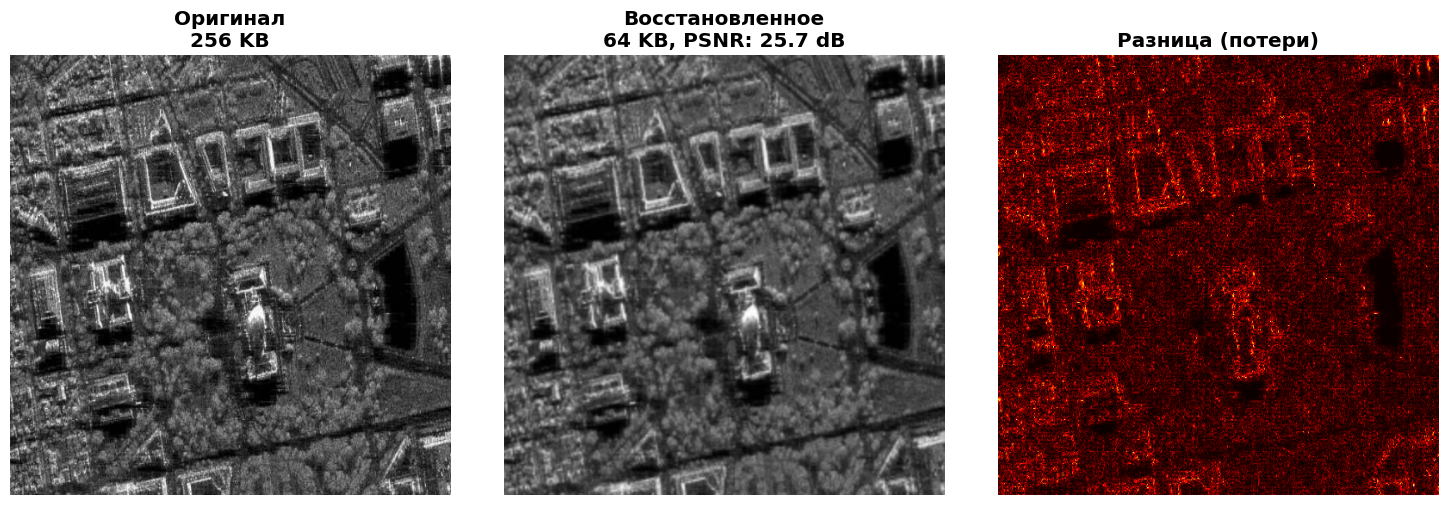

In [ ]:
# Визуализация
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(img, cmap='gray')
axes[0].set_title(f'Оригинал\n{original_size//1024} KB', fontweight='bold')
axes[0].axis('off')

axes[1].imshow(restored, cmap='gray')
axes[1].set_title(f'Восстановленное\n{compressed_size//1024} KB, PSNR: {psnr:.1f} dB', fontweight='bold')
axes[1].axis('off')

diff = cv2.absdiff(img, restored)
axes[2].imshow(diff, cmap='hot')
axes[2].set_title('Разница (потери)', fontweight='bold')
axes[2].axis('off')

plt.tight_layout()
plt.show()